In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
# load train, test, validation splits
saved_dir = 'D:/JATHURSH/Jupyter_notebook_projects/DrowsinessDetectionOnCombinedDataset/saved_data/train_test_val_splits_preprocessed_combined_dataset/'

X_train = np.load(saved_dir + 'X_train.npy')

X_val = np.load(saved_dir + 'X_val.npy')

y_train = np.load(saved_dir + 'y_train.npy')

y_val = np.load(saved_dir + 'y_val.npy')

In [3]:
# pretrained model - MobileNetV2
# all should be numpy arrays or tensors before giving it to MobileNetV2
"""
    tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=None,                 # Shape of input data (MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.) 
    alpha=1.0,                        # Width multiplier for controlling network width (default is 1.0)
    include_top=True,                 # Include fully connected top layers (default is True)
    weights='imagenet',               # Weight initialization ('imagenet' for pre-trained weights, None for random initialization)
    input_tensor=None,                # Optional input tensor (default is None)
    pooling=None,                     # Pooling type for the last layer ('avg', 'max', or None; default is None)
    classes=1000,                     # Number of output classes (default is 1000 for ImageNet)
    classifier_activation='softmax',   # Activation function for output layer (default is 'softmax')
    **kwargs                          # Additional keyword arguments
    )
"""
# we dont have to set anything and keep its default values
MobileNetV2_model = tf.keras.applications.mobilenet_v2.MobileNetV2()
    
# Make all layers in the model non-trainable - freeze
for layer in MobileNetV2_model.layers:
    layer.trainable = False

# for reproducability - can be used between different runtimes
tf.random.set_seed(0)

# Get the base model's input and output
base_input = MobileNetV2_model.layers[0].input
base_output = MobileNetV2_model.layers[-3].output
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_output)

dense_layer = tf.keras.layers.Dense(224, activation='relu')(global_average_layer) 
dropout_layer = tf.keras.layers.Dropout(0)(dense_layer)
final_output = tf.keras.layers.Dense(1)(dropout_layer)
final_output = tf.keras.layers.Activation("sigmoid")(final_output)

In [4]:
drowsiness_detection_model = tf.keras.Model(
    inputs=base_input,
    outputs=final_output
)

In [5]:
# Compile and train the model using X_train - preprocessed as input
initial_learning_rate = 0.001

# Use the ReduceLROnPlateau learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
)

drowsiness_detection_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), 
                                   loss='binary_crossentropy', 
                                   metrics=['accuracy'])

history_of_model = drowsiness_detection_model.fit(
                               X_train, 
                               y_train, 
                               epochs=100, 
                               batch_size=32, 
                               validation_data=(X_val, y_val),
                               callbacks=[tf.keras.callbacks.EarlyStopping(patience=5), lr_scheduler])

Epoch 1/100
1122/1122 [==============================] - 1214s 1s/step - loss: 0.1427 - accuracy: 0.9436 - val_loss: 0.1124 - val_accuracy: 0.9564 - lr: 0.0010
Epoch 2/100
1122/1122 [==============================] - 1277s 1s/step - loss: 0.1015 - accuracy: 0.9613 - val_loss: 0.1190 - val_accuracy: 0.9542 - lr: 0.0010
Epoch 3/100
1122/1122 [==============================] - 810s 722ms/step - loss: 0.0896 - accuracy: 0.9647 - val_loss: 0.0946 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 4/100
1122/1122 [==============================] - 816s 727ms/step - loss: 0.0797 - accuracy: 0.9683 - val_loss: 0.0975 - val_accuracy: 0.9620 - lr: 0.0010
Epoch 5/100
1122/1122 [==============================] - 817s 728ms/step - loss: 0.0737 - accuracy: 0.9713 - val_loss: 0.0922 - val_accuracy: 0.9646 - lr: 0.0010
Epoch 6/100
1122/1122 [==============================] - 812s 724ms/step - loss: 0.0683 - accuracy: 0.9735 - val_loss: 0.0853 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 7/100
1122/1122 [=========

In [6]:
training_loss = history_of_model.history['loss']
validation_loss = history_of_model.history['val_loss']

training_accuracy = history_of_model.history['accuracy']
validation_accuracy = history_of_model.history['val_accuracy']

# Calculate the number of training epochs:
# - `len(training_loss)` calculates the length of the training_loss list, which typically
#   contains the loss value at the end of each training epoch.
# - This length tells us how many epochs the machine learning model was trained for.

# Create a range of values representing epochs:
# - `range(1, len(training_loss) + 1)` generates a Python range object starting from 1 and
#   ending at the length of the training_loss list plus one.
# - The +1 is added to ensure that the range includes values up to the number of epochs.
# - This range is often used as the x-axis when plotting training metrics against the
#   number of training iterations (epochs).
epochs = range(1, len(training_loss) + 1)

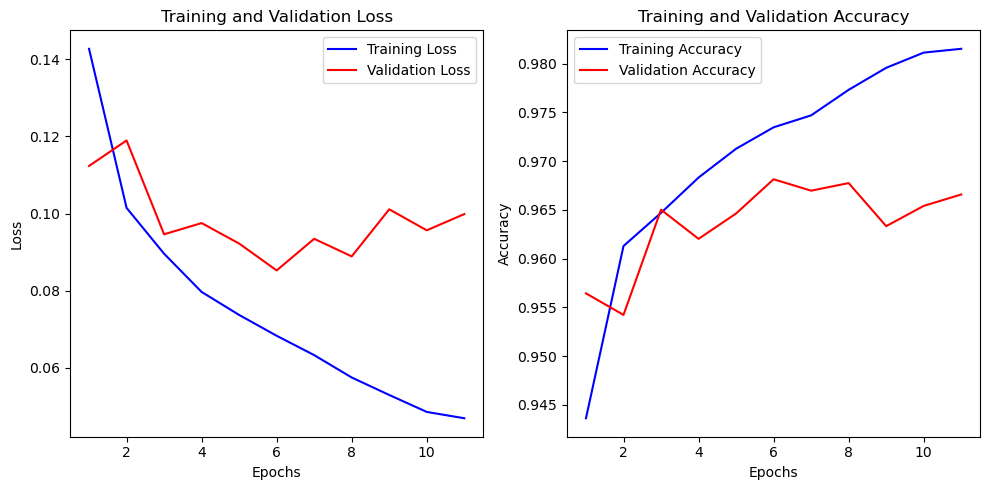

In [7]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# free up memory
del X_train
del X_val
del y_train
del y_val

In [9]:
# load test splits
saved_dir = 'D:/JATHURSH/Jupyter_notebook_projects/DrowsinessDetectionOnCombinedDataset/saved_data/train_test_val_splits_preprocessed_combined_dataset/'

X_test = np.load(saved_dir + 'X_test.npy')

y_test = np.load(saved_dir + 'y_test.npy')

In [10]:
drowsiness_detection_model.evaluate(X_test, y_test)

241/241 [==============================] - 135s 557ms/step - loss: 0.0935 - accuracy: 0.9693


[0.0934990867972374, 0.9693227410316467]

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Make predictions using trained model on the test dataset
y_pred = drowsiness_detection_model.predict(X_test)

241/241 [==============================] - 136s 557ms/step


In [12]:
y_pred, y_test

(array([[3.1940562e-01],
        [3.1869967e-02],
        [3.5657783e-06],
        ...,
        [4.9624545e-03],
        [1.2060290e-03],
        [9.9996471e-01]], dtype=float32),
 array([0, 0, 0, ..., 0, 0, 1]))

In [13]:
# Convert y_pred probabilities to binary predictions (0 or 1), threshold = 0.5
y_pred_binary = np.round(y_pred)
y_pred_binary

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [14]:
# create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

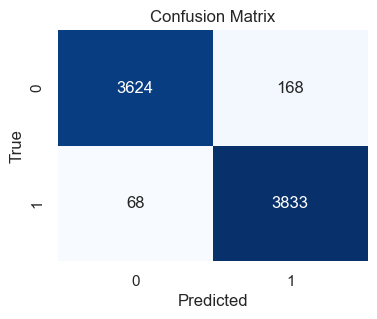

In [15]:
# Create a heatmap of the confusion matrix using seaborn
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.0)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# create classification report
class_report = classification_report(y_test, y_pred_binary)
print(class_report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3792
           1       0.96      0.98      0.97      3901

    accuracy                           0.97      7693
   macro avg       0.97      0.97      0.97      7693
weighted avg       0.97      0.97      0.97      7693



1 - means open

In [17]:
# Save the model architecture and weights
save_dir = 'D:/JATHURSH/Jupyter_notebook_projects/DrowsinessDetectionOnCombinedDataset/saved_data/models/'

drowsiness_detection_model.save(save_dir + 'dr_det_model_1.h5')

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# Save the history object to a file
with open(save_dir + 'dr_det_model_1_history.pkl', 'wb') as file:
    pickle.dump(history_of_model.history, file)